### Prepare radiation input for discretization ####
Calculate average daily radiation over the snow-melting period. This step includes:
1. calculate daily radiation based on dem, slope, aspect and the day of year (DOY). One output per DOY.
2. calculate the period mean daily radiation.
3. check the correctness of radiation.<br>

Note that it is better to run this code on high-performance computers because the 1st step is time-and-memory comsuming.

In [3]:
# import libraries
import os, shutil
import geospatial_functions.utils as ut
import geopandas as gpd
import rasterio as rio
import numpy as np
from tqdm import tqdm

In [4]:
# common paths
control_file = 'control_active.txt'
root_path = ut.read_from_control(control_file, 'root_path')
source_path = ut.read_from_control(control_file, 'source_path')
domain_name = ut.read_from_control(control_file, 'domain_name')
domain_path = os.path.join(root_path, domain_name)
plot_path = os.path.join(domain_path, 'plot')

In [ ]:
# projection system
proj4=ut.read_from_control(control_file, 'proj4') 
dst_crs = rio.crs.CRS.from_string(proj4)

In [5]:
# domain data
domain_dem_raster = ut.specify_file_path(control_file, 'domain_dem_raster')  
domain_slope_raster = ut.specify_file_path(control_file, 'domain_slope_raster')  
domain_aspect_raster = ut.specify_file_path(control_file, 'domain_aspect_raster')
domain_radiation_raster = ut.specify_file_path(control_file, 'domain_radiation_raster')

domain_gru_prj_shp = ut.specify_file_path(control_file, 'domain_gru_prj_shp') 
domain_stream_shp = ut.specify_file_path(control_file, 'domain_stream_shp')

#### Define radiation calcultion configurations ####

In [6]:
# start and end DOYs of the radiation caculation period
first_day = 75               # March 15 (temperature becomes above zero)
last_day = 167               # June 15 (snowpack disappears)
ndays = last_day-first_day+1 # total number of days for radiation calulation

In [7]:
# path to store daily radiation. One output per DOY. 
opath=os.path.join(domain_path, 'radiation_doy')
if not os.path.exists(opath):
    os.makedirs(opath)
    
# path to store job submission files.    
command_path=os.path.join(domain_path, 'radiation_doy_command')
if os.path.exists(command_path):
    shutil.rmtree(command_path) 
os.makedirs(command_path)

In [8]:
# code to calculate daily radiation. Copy this code to the command folder for use later.
# This calculation code is based on the reference:Allen, R.G., Trezza, R. and Tasumi, M., 2006. 
# Analytical integrated functions for daily solar radiation on slopes. Agricultural and Forest Meteorology, 139(1-2), pp.55-73.
script_file='./radiation_wind_functions/calculate_radiation.py'
code = shutil.copy(script_file, command_path)

#### 1. Calculate daily radiation over a evaluation period ####
If user runs this on a local machine, daily radiation is calculated day-by-day. Therefore, the entire process may take a long time depending on the doamin size and period length. In contrast, if user runs this on a high-performance cluster, daily radiaiton is calculated via jobs, and all jobs can be run simutanously, which saves time.

In [7]:
os.chdir(command_path)
for i in tqdm(range(ndays)):
    DOY = first_day+i

    # create job submission file
    command_file='qsub_DOY'+str(DOY)+'.sh'
    command_file_path = os.path.join(command_path,command_file)
    if os.path.exists(command_file_path):
        os.remove(command_file_path)

    # ------------------------------------------------------------------
    # NEED AJUSTMENTS BASED ON CLUSTERS!!!
    # This is for cheyenne.
    with open(command_file_path,'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#PBS -N SwDOY'+str(DOY)+'\n')
        f.write('#PBS -A P48500028\n')
        f.write('#PBS -q regular\n')
        f.write('#PBS -l walltime=00:15:00\n')
        f.write('#PBS -l select=1:ncpus=1:mpiprocs=1\n') 
        f.write('#PBS -j oe\n\n')
        f.write('export TMPDIR=/glade/scratch/hongli/temp\n')
        f.write('mkdir -p $TMPDIR\n\n')         
        f.write('module load peak_memusage\n\n') # monitor peak memory usage   
        # Note: cheyenne usable memory per compute node is 45GB.
        
        # To put both single quotes and double quotes inside of a string, wrap the string in triple quotes.
        f.write("""peak_memusage.exe %s %s %s %s %s %s '"%s"' %s"""%\
                ('/glade/u/home/hongli/tools/miniconda3/envs/conda_hongli/bin/python',
                 code,
                 domain_dem_raster,    
                 domain_slope_raster,  
                 domain_aspect_raster, 
                 str(DOY),  
                 proj4,
                 opath))                
    # ------------------------------------------------------------------
    
    # submit job
    os.system('chmod 740 '+command_file)
    os.system('qsub '+command_file)  # this enables job run on cluster
#     os.system('./'+command_file)   # this enables run on a local machine

100%|██████████| 93/93 [01:32<00:00,  1.01it/s]


#### 2. Calculate average daily radiation ####

In [8]:
# read daily radiation over the period
for i in np.arange(ndays):
    DOY = first_day+i
    sw_DOY_raster=os.path.join(opath,'sw_DOY'+str(DOY)+'.tif')

    # read DOY radiation 
    with rio.open(sw_DOY_raster) as ff:
        sw = ff.read(1)
        mask = ff.read_masks(1)
        sw_ma = np.ma.masked_array(sw,mask==0)
        
        out_meta = ff.meta.copy()
        nodatavals = ff.nodatavals
        
    # create a 3d array to store all DOY radiations
    if i == 0:
        sw_all = sw_ma[:,:,np.newaxis]
        sw_all = np.repeat(sw_all, ndays, axis=2) # shape (ny,nx,ndays)
    
    # assign value
    sw_all[:,:,i] = sw_ma

# calculate period mean radiation    
sw_avg = np.ma.mean(sw_all,axis = 2)

# save to raster
sw_avg_value = sw_avg.filled(fill_value=nodatavals)  # return a copy of self, with masked values filled with a given value.
sw_avg_ma = np.ma.masked_array(sw_avg_value,mask==0) # assign mask from sw_DOY
sw_avg_ma = sw_avg_ma.astype(sw_ma.dtype)           # change data type to sw_ma's.
with rio.open(domain_radiation_raster, 'w', **out_meta) as outf:
    outf.write(sw_avg_ma, 1)   

#### 3a. Check CDF of average daily radiation ####

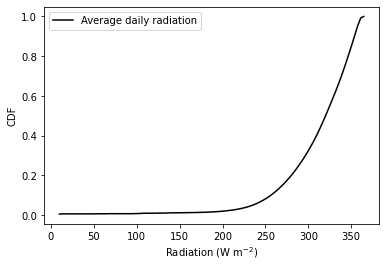

In [10]:
import matplotlib.pyplot as plt 

# Choose how many bins you want here
num_bins = 100

# raw sw and its area-based cdf
with rio.open(domain_radiation_raster) as ff:
    sw  = ff.read(1)
    mask = ff.read_masks(1)
origin_counts, origin_bin_edges = np.histogram(sw[mask!=0], bins=num_bins)

cum_counts = np.cumsum(origin_counts)
total_count = cum_counts[-1]
origin_cdf = cum_counts/float(total_count)

# Plot comparatives cdf
fig, ax = plt.subplots()
ax.plot(origin_bin_edges[1:], origin_cdf, '-k', label='Average daily radiation')
plt.xlabel("Radiation (W m$^{-2}$)")
plt.ylabel("CDF")
plt.legend(loc='best')
plt.show()

#### 3b. Check distribution of average daily radiation ###

<Figure size 432x288 with 0 Axes>

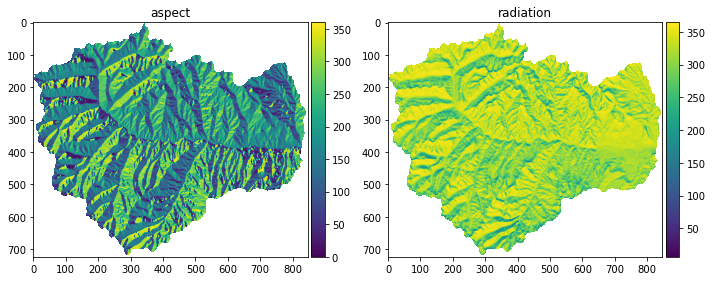

In [7]:
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def read_raster(file):   
    with rio.open(file) as ff:
        data  = ff.read(1)
        mask = ff.read_masks(1)
    data_ma = np.ma.masked_array(data, mask==0)
    return data_ma

def plot_locatable_axes(data, ax):
    # reference: https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data)
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()

plt.figure()
f, ax = plt.subplots(1,2, figsize=(10,10)) 

asp_ma = read_raster(domain_aspect_raster)
plot_locatable_axes(asp_ma, ax[0])
ax[0].set_title('Aspect')

sw_ma = read_raster(domain_radiation_raster)
plot_locatable_axes(sw_ma, ax[1])
ax[1].set_title('Radiation')

plt.tight_layout()
plt.show()